# Spot the Classifiers
### By Kathrine Gibson and Lucy Tibbetts

## Introduction
For our final project, we investigated how different audio features affect song popularity. To do so, we used [this dataset from Kaggle](https://www.kaggle.com/tomigelo/spotify-audio-features). The dataset contains the artist name, track id, track name, audio features, and popularity for over 116k songs on Spotify. Popularity was calculated based on the number of plays (as of December 3, 2018) on a scale of 0 to 100. We found that our k-NN classifier was the most accurate at predicting popularity, followed by our decision tree classifier and our Naive Bayes classifier.

## Data Analysis

In our dataset, there are thirteen audio features: acousticness, danceability, duration, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time signature, and valence. All of this data was gathered via Spotify's Web API. To determine which audio features to use, we created graphs of each feature and popularity:

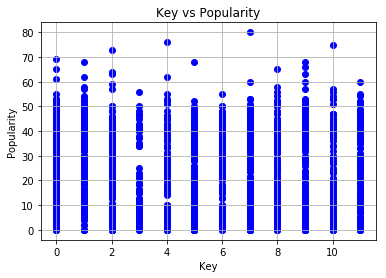

In [3]:
import numpy as np
import utils

audio_data = []
utils.read_file_to_table("small_audio_data.csv", audio_data)
headers = ["Acousticness", "Danceability", "Duration", "Energy", "Instrumentalness", "Key",
               "Liveness", "Loudness", "Mode", "Speechiness", "Tempo", "Time Signature", "Valence"]

# an example of a non-interesting audio feature:
xlabel = str(headers[5])
xaxis_column = utils.get_column(audio_data, 5)
yaxis_column = utils.get_column(audio_data, 13)
utils.create_scatter_plot(xaxis_column, yaxis_column, xlabel)

As you can see, there isn't a noticable correlation between different keys and song popularity. All keys had similar ranges: from 0 to around 70.

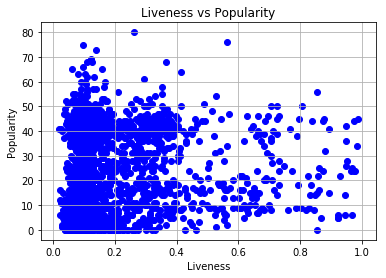

In [2]:
# an example of an interesting audio feature:
xlabel = str(headers[6])
xaxis_column = utils.get_column(audio_data, 6)
yaxis_column = utils.get_column(audio_data, 13)
utils.create_scatter_plot(xaxis_column, yaxis_column, xlabel)

From the graph above, we can see a clear correlation between liveness and song popularity. The more live a song is, the less popular it is.

After looking at the graphs, we decided not to use key, mode, or time signature because these features did not appear to be strongly correlated with popularity. 

Our dataset didn't need much cleaning, but we chose to remove the first three columns of the table (artist name, track id, and track name) since we were most interested in analyzing the audio features themselves. We first created graphs using every song in the dataset (116k rows), but since our classifiers take a significant amount of time to run, we created a smaller file with only the first 2,000 songs. We also graphed the data from this file to make sure the graphs were similar to the graphs generated using the entire dataset. 

## Classification Results

### KNN Classifier

We next implemented our own k-NN classifier to predict a song's popularity using the ten most interesting audio features. Most of the audio features are already on a 0 to 1 scale, but we had to normalize duration, loudness, and tempo, as seen below. We first ran the classifier without discretizing popularity, and our accuracy was extremely low. This result was not unexpected because the difference between a popularity score of 40 and 41, for example, is fairly insignficant. Ultimately, we decided to discretize popularity into 4 bins (>=25, >=50, >=75, and >=100) prior to classification.

In [ ]:
import utils 

trimmed_data = []
utils.read_file_to_table("small_audio_data.csv", trimmed_data, [0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13])

duration = utils.get_column(trimmed_data, 2)
normalized_duration = utils.normalize(duration)
loudness = utils.get_column(trimmed_data, 6)
normalized_loudness = utils.normalize(loudness)
tempo = utils.get_column(trimmed_data, 8)
normalized_tempo = utils.normalize(tempo)

for i in range(len(trimmed_data)):
    trimmed_data[i][2] = normalized_duration[i]
    trimmed_data[i][6] = normalized_loudness[i]
    trimmed_data[i][8] = normalized_tempo[i]
    trimmed_data[i][-1] = utils.discretize_popularity(trimmed_data[i][-1])

After normalizing our data, we created ten stratified cross folds in order to determine the accuracy of our k-NN classifier.

In [ ]:
folds = utils.stratified_cross_folds(trimmed_data, 10)
num_correct = 0
for i in range(0, 10):
    train, test = utils.set_up_train_test(i, folds)
    actual_popularities = [x[-1] for x in test]
    predicted_popularities = utils.knn_classifier(train, test)
    for i in range(len(test)):
        if actual_popularities[i] == predicted_popularities[i]:
            num_correct += 1
accuracy = num_correct / len(trimmed_data)
print("Accuracy kNN: " + str(round(accuracy * 100, 2)) + "%")

As you can see, the accuracy of our k-NN classifier was about 74.4% when using stratified cross folds and the first 2000 rows of our dataset. We initially set k=5 and then experimented with different values of k. In the code above, we are using k=8, which led to a slight increase in accuracy. Overall, however, the value of k did not seem to significantly affect the accuracy of our classifier.

### Ensemble Classifier

Next, we implemented a homogeneous k-NN ensemble classifier with six weak learners to see if we could improve upon the accuracy of a single classifier. Each of these learners uses a different but overlapping subset of four attributes. The final prediction for each instance is determined using simple majority voting.

In [ ]:
num_correct_ensemble = 0
for i in range(10):
    train, test = utils.set_up_train_test(i, folds)
    actual_popularities = [x[-1] for x in test]
    predicted_popularities = []
    for instance in test:
        predictions = []
        for j in range(6):
            training_subset = train[j:j+4]
            prediction = utils.compute_class_knn(instance, training_subset)
            predictions.append(prediction)
        # use simple majority voting
        np_arr = np.array(predictions)
        majority_vote = np.bincount(np_arr).argmax()
        predicted_popularities.append(majority_vote)
    for i in range(len(test)):
        if predicted_popularities[i] == actual_popularities[i]:
            num_correct_ensemble += 1
accuracy_ensemble = num_correct_ensemble / len(trimmed_data)
print("Accuracy ensemble kNN: " + str(round(accuracy_ensemble * 100, 2)) + "%")

Somewhat surprisingly, the accuracy of our ensemble classifier (around 43%) was actually lower than that of our initial k-NN classifier by about 30%. This decrease in accuracy may be a result of overfitting since each classifier was trained with a smaller number of attributes.

### Sci-kit Learn

We then compared the accuracy of our classifier to the accuracy of the scikit-learn k-NN:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

df = pd.DataFrame(trimmed_data)
X = np.array(df.iloc[:, 0:9])  # features
y = np.array(df.iloc[:, 10])  # class label (popularity)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)
prediction = knn.predict(X_test)
print("Scikit-learn accuracy (kNN): " + str(round(accuracy_score(y_test, prediction) * 100, 2)) + "%")

As you can see above, the accuracy of the scikit-learn k-NN classifier (around 73%) was actually fairly similar to the accuracy of our own singular k-NN classifier. 

### Decision Trees

With k-NN done, we moved onto an implementation of a TDIDT decision tree classifier. Popularity was already discretized, all attributes were already normalized, and our fingers were ready to pitter patter, so we began with some declarations of variables that the classifier would need:


In [ ]:
 col_names = ["acousticness", "danceability", "duration", "energy",
             "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence", "popularity"]

# all possible values for each attribute
att_domains = {0: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               1: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               2: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               3: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               4: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               5: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               6: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               7: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               8: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               9: [">=0.25", ">=0.50", ">=0.75", ">=1.0"],
               10: [">=25", ">=50", ">=75", ">=100"]}

class_index = len(col_names) - 1

# att_indexes is a list of attributes to use for building the tree
att_indexes = list(range(len(col_names) - 1))

It's looking beautiful, so now let's implement our classifer by using the ten stratified cross folds previously created:

In [ ]:
import tree_utils
num_correct = 0
for i in range(0, 10):  
    train, test = utils.set_up_train_test(i, folds)
    actual_popularities = [x[-1] for x in test]
    att_indexes = list(range(len(col_names) - 1))
    predicted_popularities = tree_utils.tree_classifier(
        train, test, att_indexes, att_domains, class_index, col_names)
    for i in range(len(test)):
        if actual_popularities[i] == predicted_popularities[i]:
            num_correct += 1
accuracy = num_correct / len(trimmed_data)
print("Accuracy Decision Tree: " + str(round(accuracy * 100, 2)) + "%")

Wonderful, our accuracy (around 52%) was nowhere near as high as the accuracy of our singular k-NN classifier, but it was higher than the accuracy of our ensemble k-NN classifier. We expected this result since decision trees are better suited for categorical attributes.

### Naive Bayes

Now it was time for our old friend, Naive Bayes. To test the accuracy of our Naive Bayes classifier, we used the same procedure as for our k-NN and decision tree classifiers: we found the total number of correct predictions from ten stratified cross folds and divided by the total number of instances. 

In [ ]:
num_correct_bayes = 0
for i in range(0, 10):
    train, test = utils.set_up_train_test(i, folds)
    priors = utils.compute_probabilities(train)
    actual_popularities_bayes = [x[-1] for x in test]
    predicted_popularities_bayes = []
    for instance in test:
        predicted_popularity_bayes = utils.naive_bayes_classifier(
            priors, instance, train)
        predicted_popularities_bayes.append(predicted_popularity_bayes)
    for i in range(len(test)):
        if actual_popularities_bayes[i] == predicted_popularities_bayes[i]:
            num_correct_bayes += 1
accuracy_bayes = num_correct_bayes / len(trimmed_data)
print("Accuracy Naive Bayes: " + str(round(accuracy_bayes * 100, 2)) + "%")

As shown above, the accuracy of our Naive Bayes was 43.1%, the same as our ensemble classifier. We predicted that this classifier would result in the lowest accuracy and lucky us, we were right! We expected that the conditional independence assumption was not valid for our dataset, i.e. we expected that the audio features are not wholly independent when predicting popularity.

## Conclusion and Future Work

Although our k-NN classifier achieved a reasonably high accuracy of nearly 75%, there are several things we would have liked to do with more time. Primarily, we would like to run the classifier on the full dataset. To do so, we would like to use Hadoop or Spark to help manage the large dataset. Secondly, we would like to experiment with creating genre-specific classifiers, e.g. group the dataset by genre and create separate classifiers based on genre. To do so, we would need to gather genre data for the rows in our dataset using the Spotify API. 